In [1]:
import json
import os
import warnings
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize

import importlib
import utils  # Import your module
from utils import model_name_mapping, metrics_name_mapping

# After making changes to utils.py, reload it
importlib.reload(utils)

# filepath = Path(__file__).parent
filepath = Path(os.path.abspath(''))
print(filepath)

metrics_name_mapping = {
    "r2": "R²",
    "mae": "MAE",
    "rmse": "RMSE",
    "stgr": "STGR",
    "stgi": "STGI",
}

/nfs/ml_lab/projects/improve/data/experiments/cross-dataset-drp-paper


In [2]:
datadir = Path('splits_averaged')
# outdir = datadir
outdir = filepath / 'results_for_paper'
os.makedirs(outdir, exist_ok=True)
# input_for_llm_dir = Path('input_for_llm')
# os.makedirs(input_for_llm_dir, exist_ok=True)

# file_format = 'eps'
# file_format = 'jpeg'
# file_format = 'png'
file_format = 'tiff'
dpi = 600

filename = 'all_models_scores.csv'
canc_col_name = 'improve_sample_id'
drug_col_name = 'improve_chem_id'

# datasets_order = ['CCLE', 'CTRPv2', 'GDSCv1', 'GDSCv2', 'gCSI']  # alphabetical order
datasets_order = ['gCSI', 'CCLE', 'GDSCv2', 'GDSCv1', 'CTRPv2']  # order by sample size
show_plot = True

all_scores = pd.read_csv(filepath / datadir / filename, sep=',')
all_scores.iloc[:3,:]

,met,split,value,src,trg,model
0,mse,0,0.006295,CCLE,CCLE,deepcdr
1,mse,1,0.005950,CCLE,CCLE,deepcdr
2,mse,2,0.005129,CCLE,CCLE,deepcdr


In [3]:
# Specify the metric
metric_name = "r2"

# Specify the models you want to include
models_to_include = []  # Replace with your desired models
# models_to_include = ["deepcdr", "graphdrp", "hidra", "lgbm", "uno"]  # Replace with your desired models
# models_to_include = ["graphdrp"]  # Replace with your desired models

In [4]:
# # Average across splits
# sc_mean = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].mean().reset_index()
# sc_std = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].std().reset_index()
# sc_mean[:3]

# Within-study results

In [5]:
# Extract all within-study results (src == trg)
df = all_scores[
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])  # src == trg
].reset_index(drop=True)
print(df.shape)
df.head()

df = df.groupby(["model", "src"]).agg(mean_splits=("value", "mean"), std_splits=("value", "std")).reset_index()

df_mean = df.sort_values(by=["src", "mean_splits"], ascending=[True, False]).reset_index(drop=True)  # compute mean
df_std = df.sort_values(by=["src", "std_splits"], ascending=[True, False]).reset_index(drop=True)    # compute std
# display(df.iloc[:7,:])

# Mean across splits
df_mean = df_mean.pivot(index="src", columns="model", values="mean_splits")#.reset_index(drop=False)
df_mean.index.name = None
df_mean.columns.name = None
df_mean = df_mean.T
df_mean = df_mean.round(3)
df_mean.index = df_mean.index.map(model_name_mapping)
df_mean = df_mean[datasets_order]
print('Mean across splits')
display(df_mean)

# Std across splits
df_std = df_std.pivot(index="src", columns="model", values="std_splits")#.reset_index(drop=False)
df_std.index.name = None
df_std.columns.name = None
df_std = df_std.T
df_std = df_std.round(3)
df_std.index = df_std.index.map(model_name_mapping)
df_std = df_std[datasets_order]
print('Std across splits')
display(df_std)

(300, 6)
Mean across splits


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.720,0.766,0.760,0.704,0.811
GraphDRP,0.736,0.746,0.765,0.733,0.855
HiDRA,0.711,0.756,0.768,0.722,0.832
LGBM,0.782,0.801,0.764,0.695,0.784
tCNNS,0.591,0.705,0.648,0.575,0.639
UNO,0.774,0.796,0.775,0.738,0.841


Std across splits


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.020,0.023,0.007,0.008,0.005
GraphDRP,0.029,0.018,0.008,0.007,0.006
HiDRA,0.027,0.020,0.011,0.007,0.005
LGBM,0.020,0.011,0.008,0.006,0.003
tCNNS,0.061,0.049,0.052,0.049,0.063
UNO,0.025,0.012,0.007,0.007,0.006


In [6]:
print('Mean across splits')
display(df_mean)

# Add new row to df_mean containing the mean of each column
datasets_mean = df_mean.mean(axis=0)
df_mean.loc['Mean across datasets'] = datasets_mean

# Add new column to df_mean containing the mean of each row
models_mean = df_mean.mean(axis=1)
df_mean['Mean across models'] = models_mean

# Assign NA to cell of (mean_dataset, mean_model)
df_mean.loc['Mean across datasets', 'Mean across models'] = np.nan
df_mean.to_csv(outdir / f'{metric_name}_mean_within_study_all_models.csv')

print('Mean across splits (including across models and datasets)')
display(df_mean)

Mean across splits


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.720,0.766,0.760,0.704,0.811
GraphDRP,0.736,0.746,0.765,0.733,0.855
HiDRA,0.711,0.756,0.768,0.722,0.832
LGBM,0.782,0.801,0.764,0.695,0.784
tCNNS,0.591,0.705,0.648,0.575,0.639
UNO,0.774,0.796,0.775,0.738,0.841


Mean across splits (including across models and datasets)


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean across models
DeepCDR,0.720,0.766000,0.760000,0.7040,0.811000,0.7522
GraphDRP,0.736,0.746000,0.765000,0.7330,0.855000,0.7670
HiDRA,0.711,0.756000,0.768000,0.7220,0.832000,0.7578
LGBM,0.782,0.801000,0.764000,0.6950,0.784000,0.7652
tCNNS,0.591,0.705000,0.648000,0.5750,0.639000,0.6316
UNO,0.774,0.796000,0.775000,0.7380,0.841000,0.7848
Mean across datasets,0.719,0.761667,0.746667,0.6945,0.793667,NaN


In [7]:
print('Std across splits')
display(df_std)

# Add new row to df_mean containing the mean of each column
datasets_std = df_std.mean(axis=0)
df_std.loc['Mean across datasets'] = datasets_std

# Add new column to df_mean containing the mean of each row
models_std = df_std.mean(axis=1)
df_std['Mean across models'] = models_std

# Assign NA to cell of (mean_dataset, mean_model)
df_std.loc['Mean across datasets', 'Mean across models'] = np.nan
df_std.to_csv(outdir / f'{metric_name}_std_within_study_all_models.csv')

print('Std across splits (including across models and datasets)')
display(df_std)

Std across splits


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.020,0.023,0.007,0.008,0.005
GraphDRP,0.029,0.018,0.008,0.007,0.006
HiDRA,0.027,0.020,0.011,0.007,0.005
LGBM,0.020,0.011,0.008,0.006,0.003
tCNNS,0.061,0.049,0.052,0.049,0.063
UNO,0.025,0.012,0.007,0.007,0.006


Std across splits (including across models and datasets)


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean across models
DeepCDR,0.020000,0.023000,0.0070,0.008,0.005000,0.0126
GraphDRP,0.029000,0.018000,0.0080,0.007,0.006000,0.0136
HiDRA,0.027000,0.020000,0.0110,0.007,0.005000,0.0140
LGBM,0.020000,0.011000,0.0080,0.006,0.003000,0.0096
tCNNS,0.061000,0.049000,0.0520,0.049,0.063000,0.0548
UNO,0.025000,0.012000,0.0070,0.007,0.006000,0.0114
Mean across datasets,0.030333,0.022167,0.0155,0.014,0.014667,NaN


In [8]:
datasets_mean

gCSI      0.719000
CCLE      0.761667
GDSCv2    0.746667
GDSCv1    0.694500
CTRPv2    0.793667
dtype: float64

In [9]:
models_mean

DeepCDR                 0.7522
GraphDRP                0.7670
HiDRA                   0.7578
LGBM                    0.7652
tCNNS                   0.6316
UNO                     0.7848
Mean across datasets    0.7431
dtype: float64

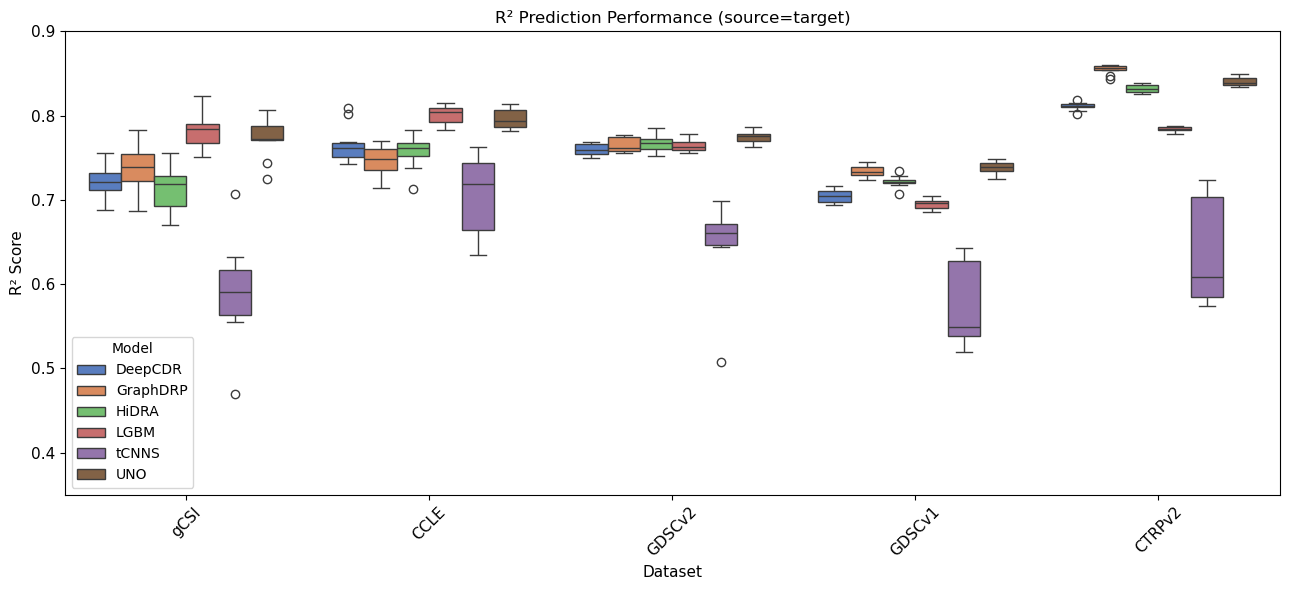

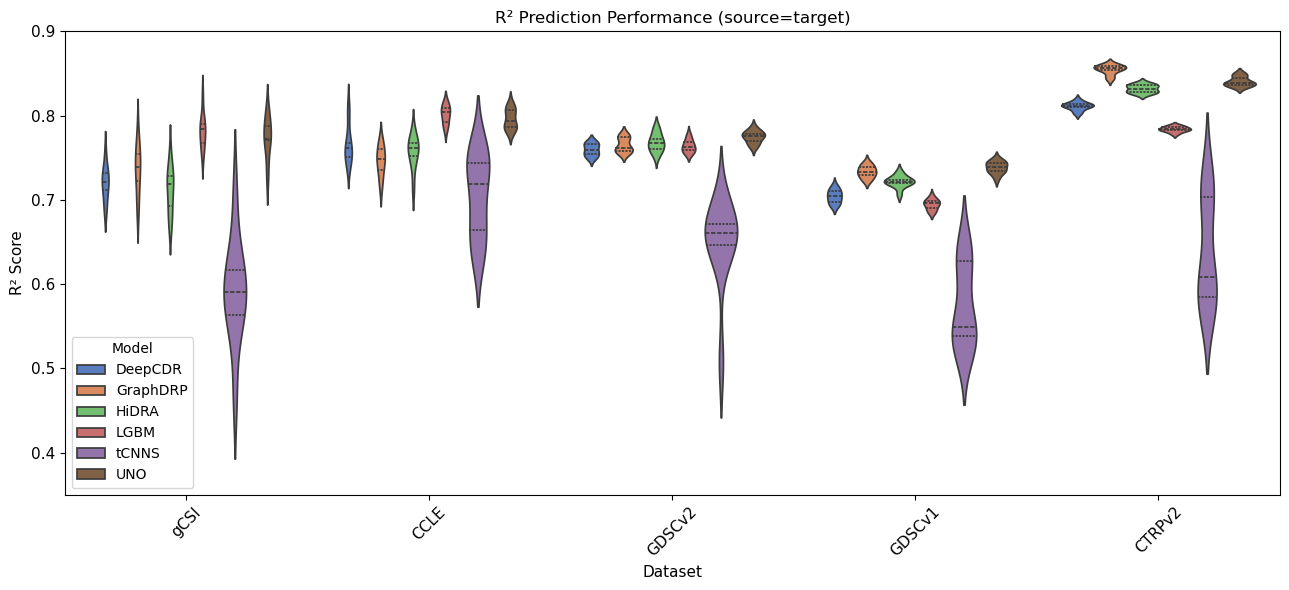

In [10]:
# --------------------------------------------------------------------------------------
# Generalization scores (violin) from a single source to all targets (src != trg)
# --------------------------------------------------------------------------------------

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

filtered_data = all_scores[
    (all_scores["model"].isin(models_to_include)) & 
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])
].reset_index(drop=True)

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_within_study(
    df=filtered_data,
    metric_name=metric_name,
    models_to_include=models_to_include,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    ymin=0.35,
    ymax=0.9,
    datasets_order=datasets_order
)

del filtered_data

/tmp/ipykernel_293059/2659238658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].map(model_name_mapping)


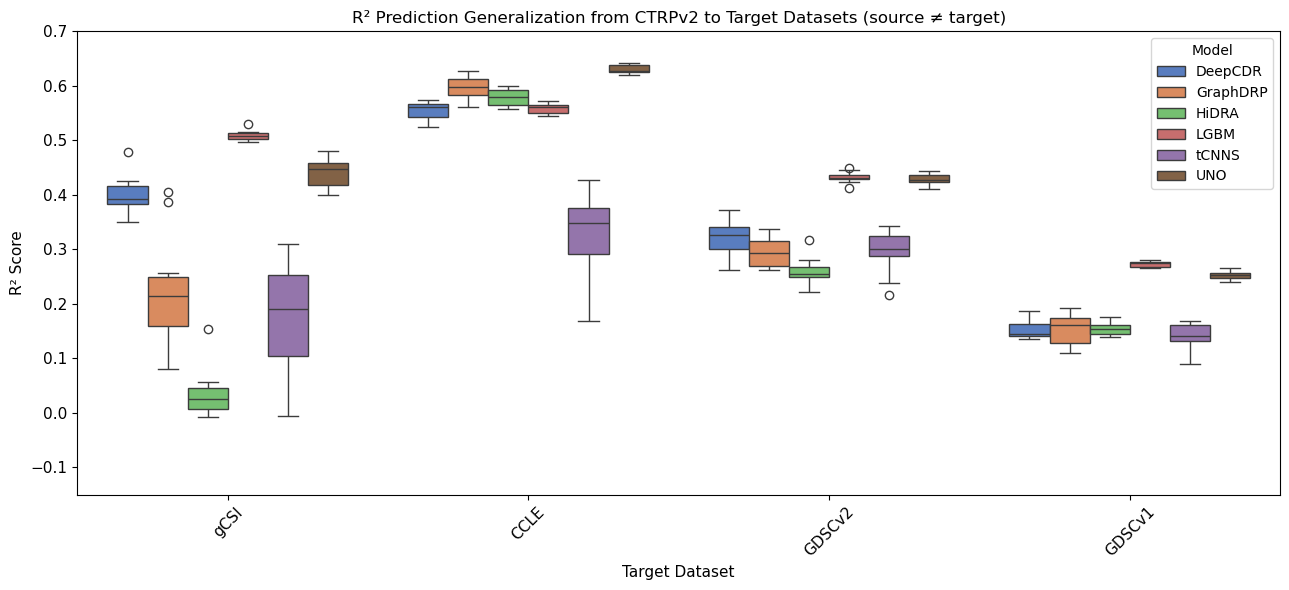

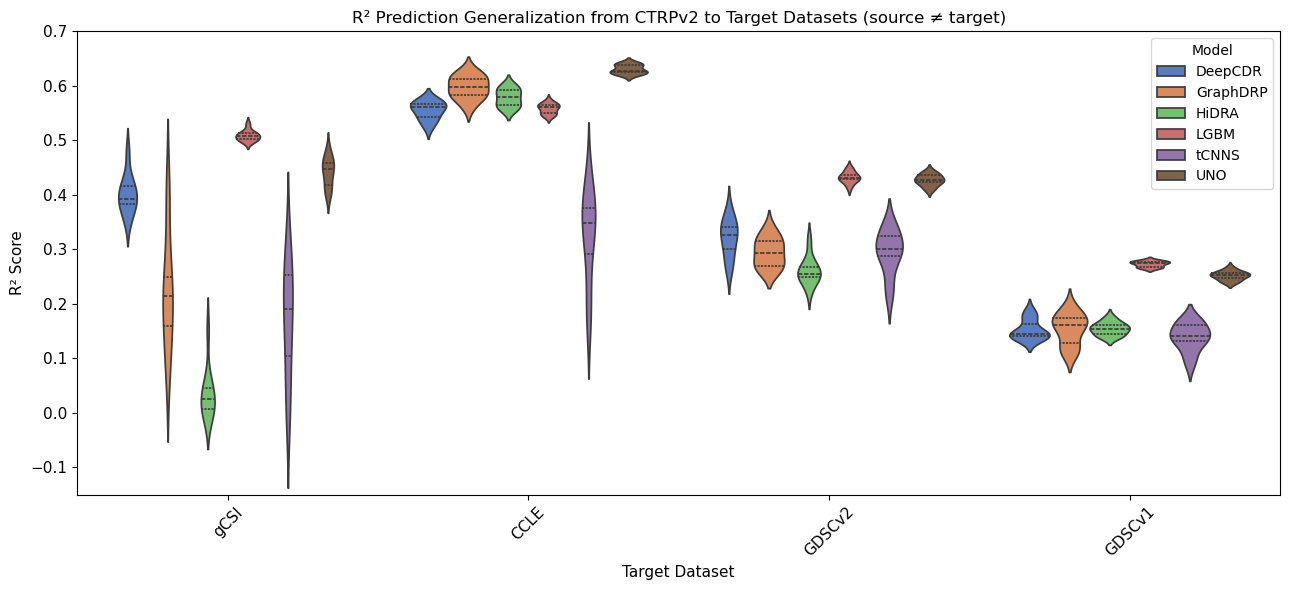

In [11]:
# --------------------------------------------------------------------------------------
# Generalization scores (boxplot) from a single source to all targets (src != trg)
# --------------------------------------------------------------------------------------

# Specify the source dataset for filtering
source_dataset = "CTRPv2"  # Replace with the specific source dataset

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

# Filter data for specific source dataset (src = CTRPv2), and R^2 metric
filtered_data = all_scores[
    (all_scores["src"] == source_dataset) &
    (all_scores["src"] != all_scores["trg"]) &  # Exclude cases where src = trg
    (all_scores["met"] == metric_name) &
    (all_scores["model"].isin(models_to_include))  # Include only specified models
]

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_cross_study(
    df=filtered_data, 
    source_dataset=source_dataset, 
    metric_name=metric_name, 
    models_to_include=models_to_include, 
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    ymin=-0.15,
    ymax=0.7,
    datasets_order=[x for x in datasets_order if x != source_dataset]
)

del filtered_data

deepcdr


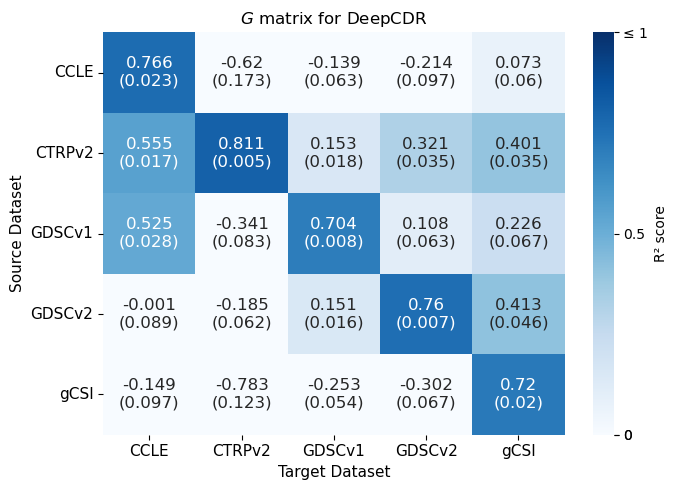

graphdrp


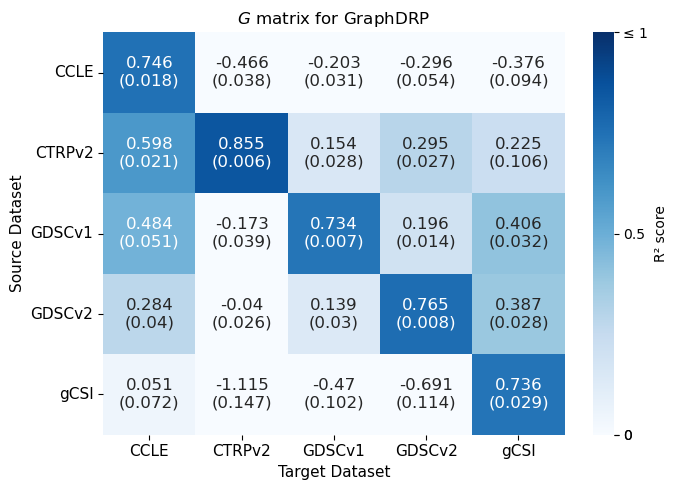

hidra


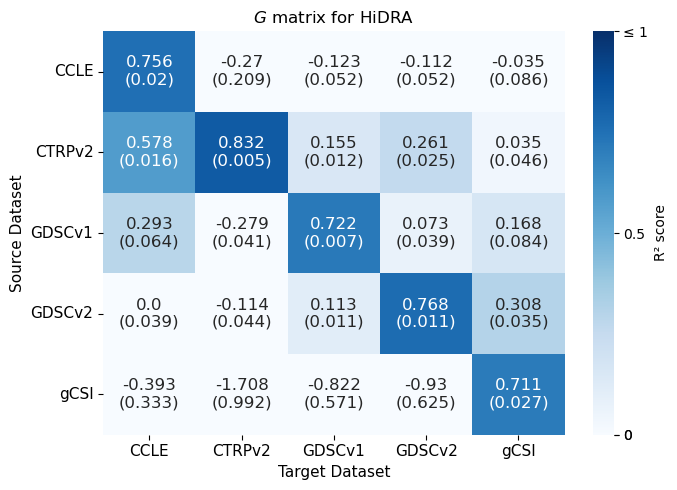

lgbm


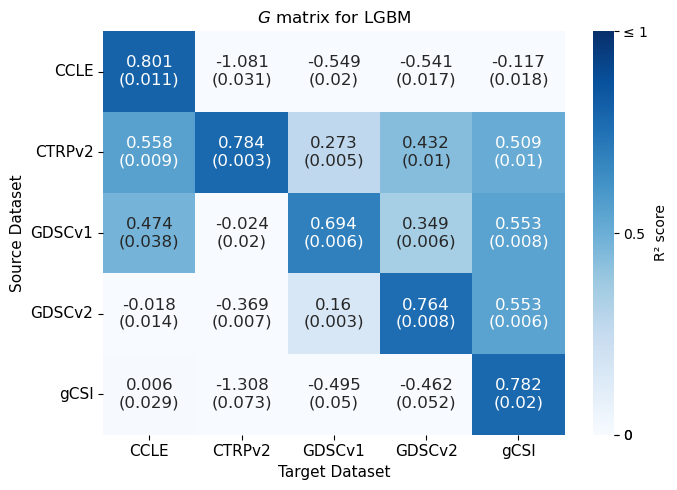

tcnns


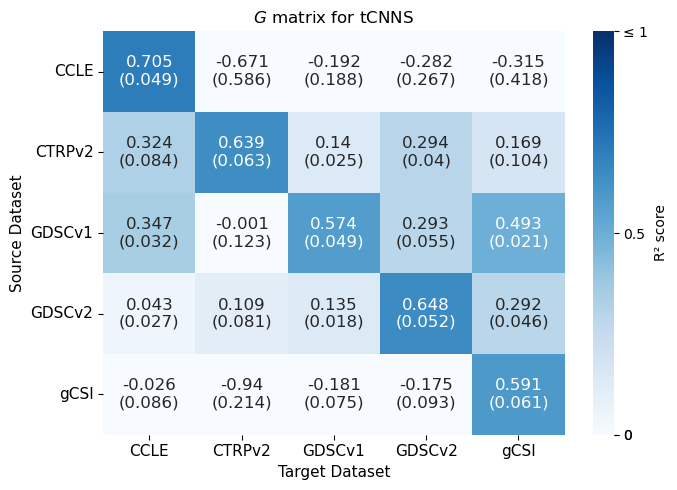

uno


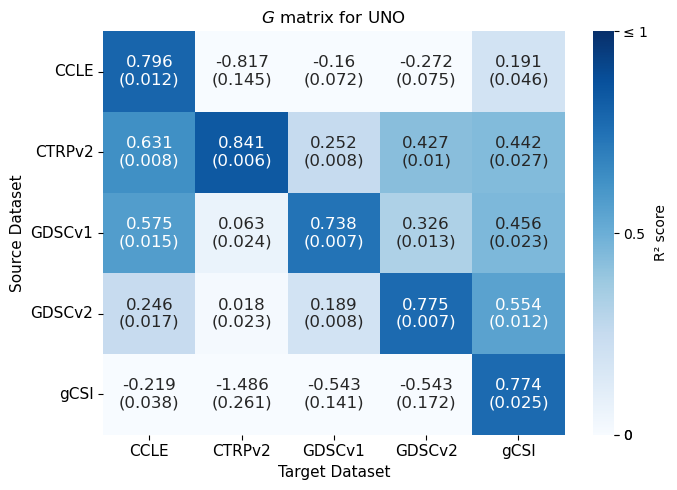

In [12]:
# Raw G matrices for all models (including std in parentheses) (Linear Scale)

G_palette = 'Blues'

G_mean_dfs = {}
G_std_dfs = {}

for model_name in model_name_mapping.keys():
    print(model_name)
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    std_csa_filename = f'{model_name}_{metric_name}_std_csa_table.csv'

    G_mean = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    G_std = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

    G_mean.set_index("src", inplace=True)
    G_std.set_index("src", inplace=True)

    # Save csv for llm
    G_mean.to_csv(outdir / f'{model_name}_{metric_name}_G_mean.csv')
    G_std.to_csv(outdir / f'{model_name}_{metric_name}_G_std.csv')

    G_mean_dfs[model_name] = G_mean
    G_std_dfs[model_name] = G_std

    utils.csa_heatmap(
        model_name=model_name, 
        metric_name=f"{metrics_name_mapping[metric_name]}",
        csa_metric_name='G',
        scores_csa_data=G_mean, 
        std_csa_data=G_std,
        vmin=0,
        vmax=1,
        outdir=outdir,
        file_format=file_format,
        dpi=dpi,
        palette=G_palette,
        decimal_digits=3,
        show=show_plot
    )

del model_name, G_mean, G_std

In [13]:
# # Print a single G matrix for a specific model
# model_id = 0
# model_name = list(G_mean_dfs.keys())[model_id]

# scores_csa_data = G_mean_dfs[model_name]
# scores_csa_data.index.name = None
# scores_csa_data.columns.name = None

# std_csa_data = G_std_dfs[model_name]
# std_csa_data.index.name = None
# std_csa_data.columns.name = None

# print(f'{model_name} r2 scores')
# print(scores_csa_data)

# print(f'{model_name} r2 stds')
# print(std_csa_data)

In [14]:
# # --------------------------------------------------------------------------------------
# ## CSA Scores with Standard Deviations (Discrete Levels Same Color)
# # --------------------------------------------------------------------------------------

# # Define discrete levels and custom colormap
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]
# colors = ["#08306b", "#2171b5", "#6baed6", "#bdd7e7", "#eff3ff"]
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Combine scores and stds for annotations
# combined_annotations = scores_csa_data.round(4).astype(str) + "\n(" + std_csa_data.round(4).astype(str) + ")"

# # Plot the combined heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(
# scores_csa_data, 
#     annot=combined_annotations.values, 
#     fmt="", 
#     cmap=cmap, 
#     norm=norm, 
#     cbar_kws={'label': 'R² Score'}
# )

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

# # --------------------------------------------------------------------------------------
# ## CSA Scores with Standard Deviations (Discrete Levels Different Colors)
# # --------------------------------------------------------------------------------------

# # Define custom levels and pale colors
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]  # Replace -float("inf") with a very small value
# colors = ["#dcd0ff", "#ffd1d1", "#ffebcc", "#ffffcc", "#d1ffd1"]  # Pale purple, red, orange, yellow, green
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Plot heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(scores_csa_data, annot=True, fmt=".2f", cmap=cmap, norm=norm, cbar_kws={'label': 'R² Score'})

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# # Finalize plot
# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

# Custom metrics (Ga, Gn, Gna)

In [15]:
# Use scores from a single model

# # Example CSA scores (R²)
# scores_csa_data = {
#     "CCLE": [0.7479, 0.5758, 0.4482, 0.3082, 0.0234],
#     "CTRPv2": [-0.4671, 0.8508, -0.1432, -0.0324, -1.1319],
#     "GDSCv1": [-0.2057, 0.1503, 0.734, 0.154, -0.4801],
#     "GDSCv2": [-0.2913, 0.2902, 0.2003, 0.7659, -0.7147],
#     "gCSI": [-0.3793, 0.2314, 0.4179, 0.3914, 0.733],
# }
# scores_csa_data = pd.DataFrame(scores_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

# # Example CSA std deviations (optional for some metrics)
# std_csa_data = {
#     "CCLE": [0.0123, 0.0406, 0.0245, 0.0364, 0.1058],
#     "CTRPv2": [0.0249, 0.0031, 0.0135, 0.0253, 0.0901],
#     "GDSCv1": [0.078, 0.0301, 0.0065, 0.0389, 0.0304],
#     "GDSCv2": [0.0453, 0.0216, 0.0262, 0.0098, 0.0448],
#     "gCSI": [0.1053, 0.1546, 0.0903, 0.1144, 0.0314],
# }
# std_csa_data = pd.DataFrame(std_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

model_name = "graphdrp"

mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
std_csa_filename = f'{model_name}_{metric_name}_std_csa_table.csv'

scores = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
stds = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

scores.set_index("src", inplace=True)
stds.set_index("src", inplace=True)

print(f'Model: {model_name}')
display(scores)
display(stds)

Model: graphdrp


,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.7463,-0.4658,-0.2034,-0.2956,-0.3757
CTRPv2,0.5975,0.8548,0.1536,0.2946,0.2248
GDSCv1,0.4837,-0.1727,0.7335,0.1963,0.4063
GDSCv2,0.2838,-0.0400,0.1392,0.7654,0.3867
gCSI,0.0507,-1.1147,-0.4700,-0.6911,0.7359


,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.017624,0.037721,0.031389,0.053909,0.094062
CTRPv2,0.020908,0.005561,0.028340,0.026835,0.105501
GDSCv1,0.051223,0.039108,0.007105,0.013770,0.032113
GDSCv2,0.039580,0.025730,0.029556,0.008478,0.027771
gCSI,0.072315,0.146593,0.102085,0.113874,0.029452


# Ga matrix

In [16]:
# Compute Ga using both implementations
Ga_bruteforce = utils.compute_aggregated_G_bruteforce(scores, normalize=False)
Ga_vectorized = utils.compute_aggregated_G_vectorized(scores, normalize=False)

# Compare results
print(f"Bruteforce Ga:\n{Ga_bruteforce}")
print(f"Vectorized Ga:\n{Ga_vectorized}")

# Check if all implementations are consistent
assert Ga_vectorized == Ga_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

Bruteforce Ga:
{'CCLE': -0.335125, 'CTRPv2': 0.31762500000000005, 'GDSCv1': 0.22840000000000002, 'GDSCv2': 0.192425, 'gCSI': -0.5562750000000001}
Vectorized Ga:
{'CCLE': -0.335125, 'CTRPv2': 0.31762500000000005, 'GDSCv1': 0.22840000000000002, 'GDSCv2': 0.192425, 'gCSI': -0.5562750000000001}


In [17]:
# Combine Ga scores from all models
Ga_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index('src', inplace=True)
    Ga = utils.compute_aggregated_G_vectorized(scores_csa_data, normalize=False)

    Ga['model'] = model_name
    Ga_list.append(Ga)

Ga_df = pd.DataFrame(Ga_list)
Ga_df.insert(loc=0, column='model', value=Ga_df.pop('model')) # place 'model' col at pos 0
Ga_df.set_index('model', inplace=True)
Ga_df.to_csv(outdir / 'Ga_table.csv')
print(Ga_df)

del model_name, scores_csa_data, Ga, Ga_list

deepcdr
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.224750  0.357575  0.129200  0.094275 -0.371600
graphdrp -0.335125  0.317625  0.228400  0.192425 -0.556275
hidra    -0.134950  0.257275  0.063550  0.076700 -0.963125
lgbm     -0.571975  0.443175  0.338050  0.081525 -0.564775
tcnns    -0.365100  0.231750  0.282875  0.144800 -0.330475
uno      -0.264450  0.438000  0.354875  0.251925 -0.697675


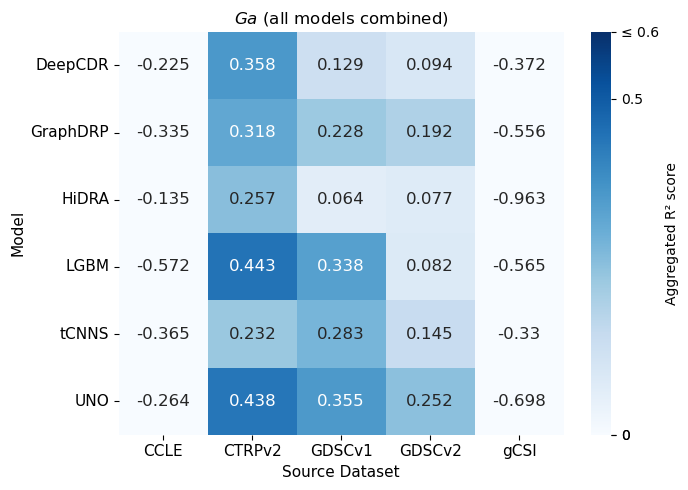

In [18]:
# Plot Ga heatmap
utils.aggregated_G_heatmap(
    metric_name=f"Aggregated {metrics_name_mapping[metric_name]}",
    csa_metric_name='Ga',
    scores_aggregated_data=Ga_df.copy(),
    # palette="RdPu",
    palette=G_palette,
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    show=show_plot
)

# Gn matrix
(this was previously Source-to-Target Generalization Ratio (STGR))

In [19]:
# Compute Gn using both implementations
Gn_bruteforce = utils.compute_Gn_bruteforce(scores)
Gn_vectorized = utils.compute_Gn_vectorized(scores)

# Convert bruteforce results to DataFrame for comparison
Gn_bruteforce_df = pd.DataFrame.from_dict(Gn_bruteforce, orient="index")

# Compare results
print(f'Bruteforce Gn:\n{Gn_bruteforce_df}')
print(f'\nVectorized Gn:\n{Gn_vectorized}')

# Check for equality
assert np.allclose(Gn_bruteforce_df, Gn_vectorized), "Gn results do not match!"
print("\nBoth implementations produce the same results!")

Bruteforce Gn:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Vectorized Gn:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
src                                                     
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Both implementations produce the same results!


deepcdr


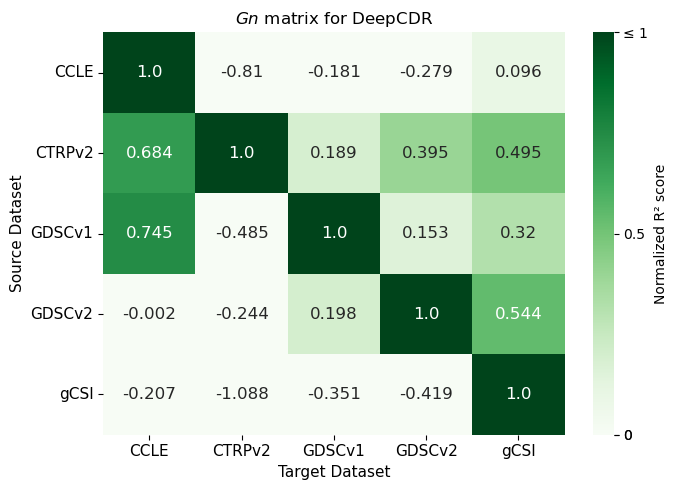

graphdrp


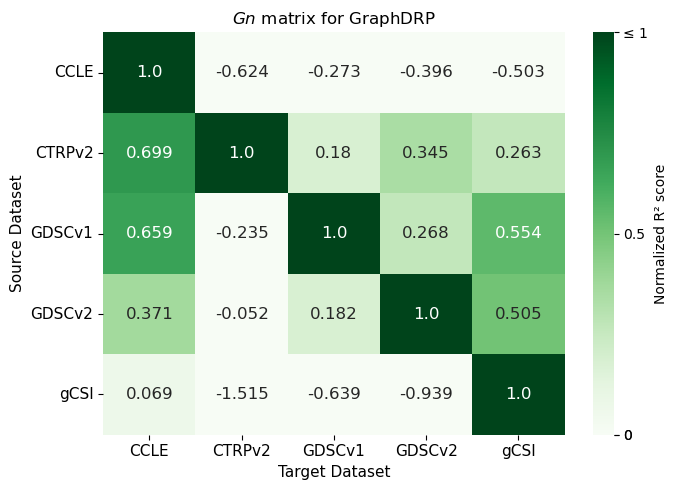

hidra


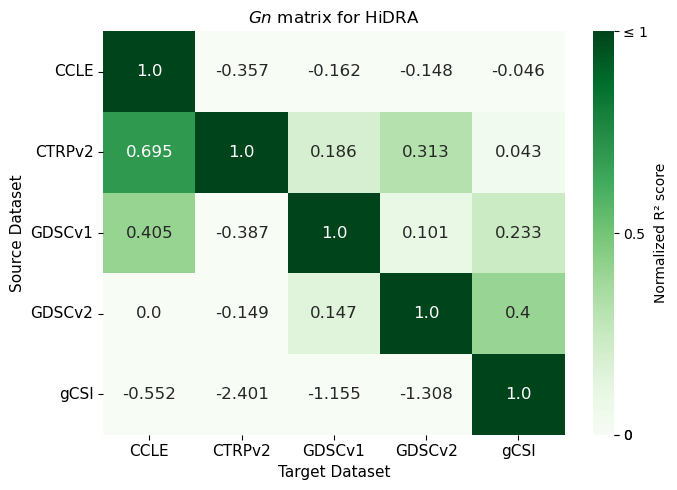

lgbm


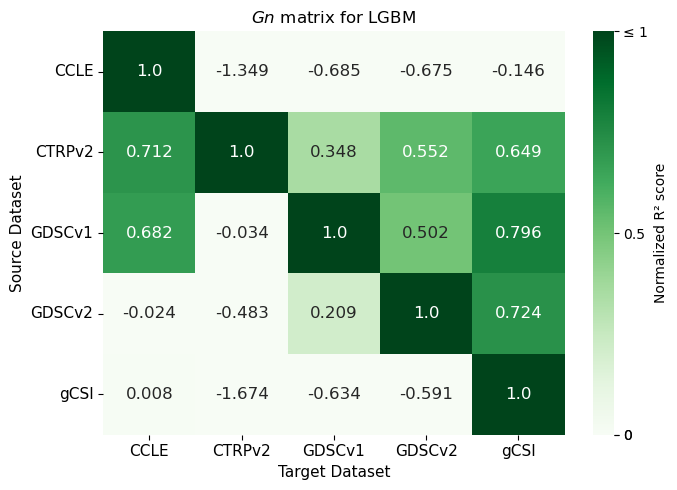

tcnns


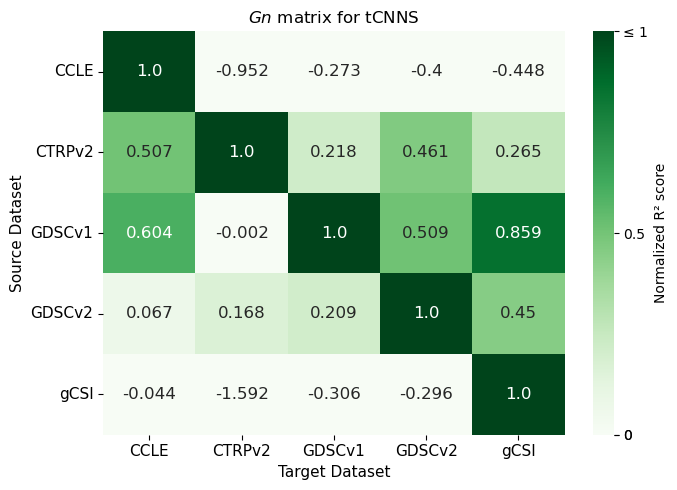

uno


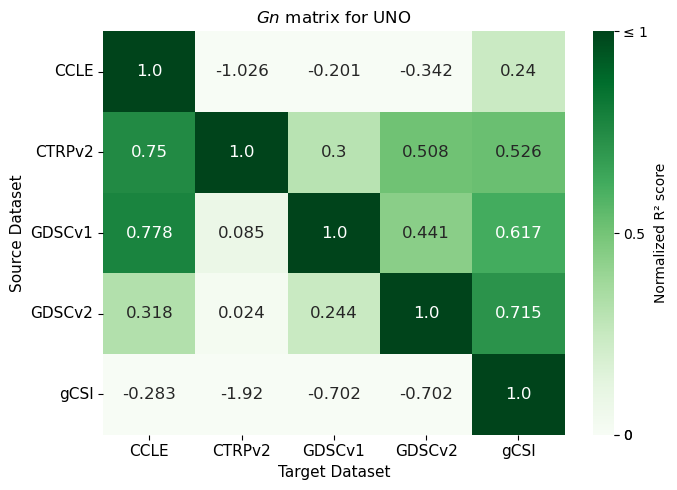

In [20]:
Gn_palette = 'Greens'

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index("src", inplace=True)
    Gn = utils.compute_Gn_vectorized(scores_csa_data)
    Gn.to_csv(outdir / f'{model_name}_{metric_name}_Gn_mean.csv') # Save csv for llm

    utils.csa_heatmap(
        model_name=model_name, 
        # metric_name="stgr",
        metric_name=f"Normalized {metrics_name_mapping[metric_name]}",
        csa_metric_name='Gn',
        scores_csa_data=Gn, 
        vmin=0,
        vmax=1,
        palette=Gn_palette,
        outdir=outdir,
        file_format=file_format,
        dpi=dpi,
        decimal_digits=3,
        show=show_plot
    )

del model_name, scores_csa_data, Gn

In [21]:
# # Print a single Gn matrix for a specific model
# model_id = 5
# model_name = list(G_mean_dfs.keys())[model_id]

# scores_csa_data = G_mean_dfs[model_name]

# Gn = utils.compute_Gn_vectorized(scores_csa_data)
# Gn.index.name = None
# Gn.columns.name = None

# print(f'{model_name} Gn')
# print(Gn)

# Gna matrix
(previously Source-to-Target Generalization Index (STGI))

In [22]:
# Compute Gna using both implementations
Gna_bruteforce = utils.compute_aggregated_G_bruteforce(scores, normalize=True)
Gna_vectorized = utils.compute_aggregated_G_vectorized(scores, normalize=True)

# Compare results
print("Bruteforce Gna:")
print(Gna_bruteforce)

print("\nVectorized Gna:")
print(Gna_vectorized)

# Check if all implementations are consistent
# assert Gna_vectorized.equals(pd.Series(Gna_bruteforce)), "Mismatch between bruteforce and simpler implementations!"
assert Gna_vectorized == Gna_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

Bruteforce Gna:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}

Vectorized Gna:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}


In [23]:
# Combine Gna scores from all models
Gna_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index('src', inplace=True)
    Gna = utils.compute_aggregated_G_vectorized(scores_csa_data, normalize=True)

    Gna['model'] = model_name
    # print(stgi)
    Gna_list.append(Gna)

Gna_df = pd.DataFrame(Gna_list)
Gna_df.insert(loc=0, column='model', value=Gna_df.pop('model')) # place 'model' col at pos 0
Gna_df.set_index('model', inplace=True)
Gna_df.to_csv(outdir / 'Gna_table.csv')
print(Gna_df)

del model_name, scores_csa_data, Gna, Gna_list

deepcdr
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.293446  0.440743  0.183497  0.124095 -0.516398
graphdrp -0.449049  0.371578  0.311384  0.251404 -0.755911
hidra    -0.178387  0.309188  0.088044  0.099831 -1.354035
lgbm     -0.713720  0.565274  0.486753  0.106694 -0.722588
tcnns    -0.518019  0.362903  0.492385  0.223388 -0.559369
uno      -0.332182  0.520994  0.480535  0.325148 -0.901622


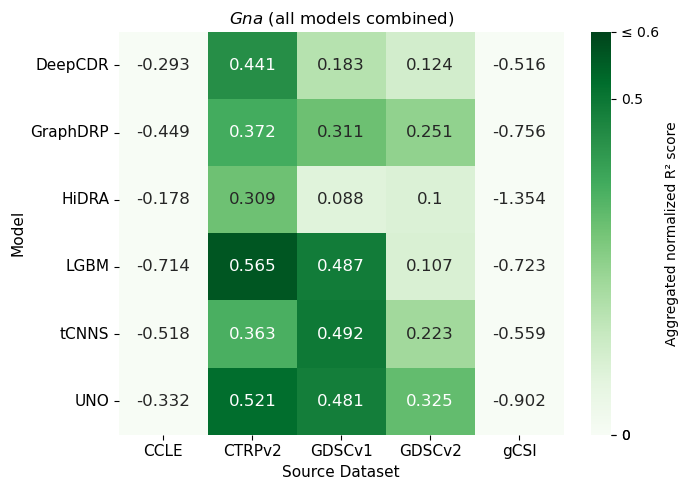

In [24]:
# Plot Gna heatmap
utils.aggregated_G_heatmap(
    metric_name=f"Aggregated normalized {metrics_name_mapping[metric_name]}",
    csa_metric_name='Gna',
    scores_aggregated_data=Gna_df.copy(),
    # palette="RdPu",
    palette=Gn_palette,
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    file_format=file_format,
    dpi=dpi,
    show=show_plot
)

In [25]:
# palette = "RdGn"

# if palette in plt.colormaps():  # Check if the palette is a valid Matplotlib colormap
#     cmap = plt.get_cmap(palette)
# else:
#     cmap = sns.color_palette(palette, as_cmap=True)  # Use Seaborn for custom palettes

# print(cmap)

In [26]:
# palette in plt.colormaps()

In [27]:
   available_colormaps = plt.colormaps()
   print(available_colormaps)

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

In [28]:
# import matplotlib
# matplotlib.__version__

# Source-to-Target Variability Ratio (STVR)

In [29]:
# # STVR (Source-to-Target Variability Ratio)
# """
# The STVR quantifies the relative variability of a model’s performance for a 
# source-target pair by comparing the variability (standard deviation) of 
# predictions to the average performance for that pair. It is designed to provide 
# insight into the stability of predictions across different source-target combinations.

# STVR evaluates stability per source-target pair, telling you how consistent or 
# erratic the model predictions are in that scenario.

# Key Characteristics
#     - Pairwise Metric: Evaluates the variability for each source-target combination,
#         enabling fine-grained analysis of prediction stability.
#     - Normalization: Normalizes the standard deviation of predictions by the mean 
#         performance, allowing for direct comparison across source-target pairs, 
#         regardless of scale.
#     - Interpretation
#         - > 1: Indicates high variability relative to the average performance, 
#             suggesting instability.
#         - 0 < STVR < 1: Indicates low variability relative to the average performance, 
#             suggesting stability.
#         - < 0: Reflects variability relative to poor performance
#     - Caveats
#         - Sensitive to both variability (numerator) and performance (denominator): 
#             Small mean performance values in the denominator can inflate the ratio,
#             potentially misrepresenting variability.
#         - Requires sufficient sample size for robust std computation.
#     - Edge Cases
#         - Zero mean performance: If mean_abs(src→trg)=0, assign a default value (e.g., 0) 
#             to avoid division by zero.

# Formula:
#     STVR[src][trg] = std_dev(src → trg) / mean_score(src → trg)
#     Where:
#         - std_dev(src→trg): Standard deviation of predictions for the source-target pair.
#         - mean_score(src→trg): Mean performance for the source-target pair.
# """

# def compute_stvr_vectorized(scores, stds):
#     """
#     Compute STVR (Source-to-Target Variability Ratio) using a vectorized approach.

#     Args:
#         scores (pd.DataFrame): DataFrame where each cell contains a performance score.
#         stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
#                              of scores for the corresponding source-target pair.

#     Returns:
#         pd.DataFrame: A DataFrame with STVR values for each source-target pair.
#     """
#     #mean_abs = scores.abs()  # Compute mean absolute score (element-wise)
#     #stvr = stds / mean_abs.replace(0, np.nan)  # Compute STVR, avoiding division by zero
#     stvr = stds / scores.replace(0, np.nan)  # Compute STVR, avoiding division by zero
#     stvr = stvr.fillna(0)  # Replace NaN values with 0 for consistency
#     return stvr


# def compute_stvr_bruteforce(scores, stds):
#     """
#     Compute STVR (Source-to-Target Variability Ratio) for each source-target pair.
#     This implementation avoids vectorized operations.

#     Args:
#         scores (pd.DataFrame): DataFrame where each cell contains a performance score.
#         stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
#                              of scores for the corresponding source-target pair.

#     Returns:
#         pd.DataFrame: A DataFrame with STVR values for each source-target pair.
#     """
#     stvr = pd.DataFrame(index=scores.index, columns=scores.columns)

#     # Iterate through each source-target pair
#     for src in scores.index:
#         for trg in scores.columns:
#             # Get mean absolute score and std deviation
#             #mean_abs = abs(scores.loc[src, trg])
#             mena_score = scores.loc[src, trg]
#             std_dev = stds.loc[src, trg]
            
#             # Compute STVR
#             #stvr.loc[src, trg] = std_dev / mean_abs if mean_abs != 0 else 0
#             stvr.loc[src, trg] = std_dev / mena_score if mena_score != 0 else 0

#     return stvr


# stvr_bruteforce = compute_stvr_bruteforce(scores, stds).apply(pd.to_numeric)
# stvr_vectorized = compute_stvr_vectorized(scores, stds).apply(pd.to_numeric)

# print(stvr_bruteforce)
# print(stvr_vectorized)

# assert np.allclose(stvr_bruteforce.values, stvr_vectorized.values,
#         atol=1e-6,  # Adjust the absolute tolerance for small rounding errors
#         rtol=1e-5,   # Adjust the relative tolerance
#         equal_nan=True), "STVR results do not match!"

# Source-to-Target Variability Index (STVI)

In [30]:
# # STVI (Source-to-Target Variability Index)
# """
# STVI summarizes the variability of a model’s performance considering all 
# source-target pairs and normalizing the overall variability (standard deviation) 
# by the overall mean absolute performance.

# STVI aggregates variability globally, helping you compare which models are more 
# stable across the board, but not telling you which datasets or source-target 
# pairs contribute to that stability or instability.
# """

# def compute_stvi_vectorized(scores, stds):
#     """
#     Compute STVI (Source-to-Target Variability Index) using a vectorized approach.

#     Args:
#         scores (pd.DataFrame): DataFrame where each cell contains a performance score.
#         stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
#                              of scores for the corresponding source-target pair.

#     Returns:
#         float: The STVI value for the entire CSA study.
#     """
#     mean_abs = scores.abs().mean().mean()  # Compute overall mean absolute score
#     overall_std_dev = stds.values.std()  # Compute overall standard deviation of stds

#     # Compute STVI
#     return overall_std_dev / mean_abs if mean_abs != 0 else 0


# def compute_stvi_bruteforce(scores, stds):
#     """
#     Compute STVI (Source-to-Target Variability Index) for the entire CSA study.
#     This implementation avoids vectorized operations for a fully brute-force calculation.

#     Args:
#         scores (pd.DataFrame): DataFrame where each cell contains a performance score.
#         stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
#                              of scores for the corresponding source-target pair.

#     Returns:
#         float: The STVI value for the entire CSA study.
#     """
#     all_scores = []
#     all_stds = []

#     # Flatten all scores and std deviations
#     for src in mean_csa_data.index:
#         for trg in mean_csa_data.columns:
#             all_scores.append(abs(mean_csa_data.loc[src, trg]))  # Collect absolute values of scores
#             all_stds.append(std_csa_data.loc[src, trg])  # Collect standard deviations

#     # Compute mean absolute score and overall standard deviation
#     mean_abs = sum(all_scores) / len(all_scores)
#     overall_std_dev = (sum((x - np.mean(all_stds)) ** 2 for x in all_stds) / len(all_stds)) ** 0.5

#     # Compute STVI
#     return overall_std_dev / mean_abs if mean_abs != 0 else 0


# stvi_bruteforce = compute_stvi_bruteforce(mean_csa_data, std_csa_data)
# stvi_vectorized = compute_stvi_vectorized(mean_csa_data, std_csa_data)

# print(stvi_vectorized)
# print(stvi_bruteforce)

# assert np.isclose(stvi_bruteforce, stvi_vectorized, equal_nan=True), "STVI results do not match!"

# Runtime Analysis

In [31]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # 1. Box Plot of Total Minutes by Model
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='model', y='tot_mins', data=df)
# plt.title('Box Plot of Total Minutes by Model')
# plt.xticks(rotation=45)
# plt.ylabel('Total Minutes')
# plt.xlabel('Model')
# plt.tight_layout()
# plt.show()

# # 2. Bar Plot of Average Total Minutes by Source
# avg_tot_mins_src = df.groupby('src')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.barplot(x='src', y='tot_mins', data=avg_tot_mins_src)
# plt.title('Average Total Minutes by Source')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Source')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 3. Line Plot of Total Minutes by Stage
# avg_tot_mins_stage = df.groupby('stage')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='stage', y='tot_mins', data=avg_tot_mins_stage, marker='o')
# plt.title('Average Total Minutes by Stage')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Stage')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 4. Heatmap of Total Minutes by Source and Target
# heatmap_data = df.pivot_table(values='tot_mins', index='src', columns='trg', aggfunc='mean')
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
# plt.title('Heatmap of Average Total Minutes by Source and Target')
# plt.ylabel('Source')
# plt.xlabel('Target')
# plt.tight_layout()
# plt.show()

In [32]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Calculate the standard error of the mean (sem)
# stage_model_src_stats['sem'] = stage_model_src_stats['std'] / stage_model_src_stats['count'] ** 0.5

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# # Create separate plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = stage_model_src_stats[stage_model_src_stats['stage'] == stage]
    
#     bar_plot = sns.barplot(x='src', y='mean', hue='model', data=stage_data, palette=colors, errorbar=None)
    
#     # Add error bars for each bar
#     for index, bar in enumerate(bar_plot.patches):
#         height = bar.get_height()
#         sem = stage_data['sem'].iloc[index]
        
#         plt.errorbar(x=bar.get_x() + bar.get_width() / 2, 
#                      y=height, 
#                      yerr=sem, 
#                      fmt='none', 
#                      c='black', 
#                      capsize=5, 
#                      elinewidth=1)

#     plt.title(f'Distribution of Total Minutes for Stage {stage} with Error Bars')
#     plt.ylabel('Average Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()

In [33]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Create separate box plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = df[df['stage'] == stage]  # Filter data for the current stage
    
#     # Create a box plot
#     sns.boxplot(x='src', y='tot_mins', hue='model', data=stage_data, palette=colors)
    
#     plt.title(f'Distribution of Total Minutes for Stage: {stage}')
#     plt.ylabel('Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()